In [1]:
import numpy as np
from scipy.fftpack import fft
import random

In [2]:
# Choose the signal frequency (0.2Hz) and the number of cycles to sample over (2) and the number of samples (50)

f_s = 0.2345
N_cycles = 1.8
N_samples = 50

# Calculate the timespan
period = 1/f_s
T =  N_cycles*period

# Set the number of terms in the Fourier series (initially, equal to the number of samples, which is bad!)

N_terms = int(N_samples/2)

random.seed(1)

In [3]:
# Calculate the spacing (in time) between data points
dt = T/N_samples

# Set up arrays to hold the time (x-axis), amplitude (y-axis), and frequencies (Fourier transform)
t = np.zeros(N_samples)
y = np.zeros(N_samples)
f = np.zeros(N_terms)

yhigh = np.zeros(1000)
ylow = np.zeros(1000)
time = np.zeros(1000)

ytReal = np.zeros(N_terms)
ytImag = np.zeros(N_terms)

yfftReal = np.zeros(N_terms)
yfftImag = np.zeros(N_terms)

power = np.zeros(N_terms)
powerfft = np.zeros(N_terms)

print (len(f), len(ytReal), len(yfftReal))

25 25 25


## Theory

The function that we will choose is:

$y(t) = sin(2 \pi f_s t)$

The Fourier approximation is given by:

$y(t) \approx \frac{a_0}{2} + \sum_{n=1}^{\infty} \left ( a_n cos(\frac{2 \pi n t}{T}) + b_n sin(\frac{2 \pi n t}{T}) \right )$

where $T$ is the time-span.

For the chosen function, we expect:

$a_0 = 0$

$a_n = 0,~for~all~n$

Since we have a single sine wave with with frequency, $f_s$, we would expect one of the $b_n$ values to be non-zero, and the rest zero.  The value of n for the single non-zero $b_n$ value can be calculated from:

$2 \pi f_s = \frac{2 \pi n}{T}$

$n = T\cdot f_s = (0.2)(10.0) = 2$

Thus, we expect:

$b_2 = 1, and~all~other~b_n=0$

In [4]:
# Create the data set.  Add a little bit of random noise into the signal.

for i in range(N_samples):
    t[i]=i*dt
    y[i]=(1.0+0.00000002*random.uniform(0,1))*np.sin(2.0*np.pi*t[i]*f_s)
    
for i in range(N_terms):
    f[i] = i/(N_terms*dt)
    
    
print (len(y),len(f),len(t))

50 25 50


# Calculating the coefficients

We will determine the coefficients by numerical integration, according to:

$a_0 = \frac{1}{T} \int_0^T f(t) dt$

$a_n = \frac{1}{T} \int_0^T f(t) cos(\frac{2 \pi n}{T} t) dt$

$b_n = \frac{1}{T} \int_0^T f(t) sin(\frac{2 \pi n}{T} t) dt$

In [5]:
from timeit import default_timer as timer

start = timer()

# Define a useful constant, because I am sick of typing it so many times!

twopiT=2.0*np.pi/T

# rather than just making things exactly zero, make them a small number, so that logarithmic plots do not fail.
epsilon = 0.001

for n in range(N_terms):
    ytReal[n]=epsilon
    ytImag[n]=epsilon
    for i in range(N_samples):
        ytReal[n] = ytReal[n] + 2.0/T*y[i]*np.cos(twopiT*n*i*dt)*dt
        ytImag[n] = ytImag[n] + 2.0/T*y[i]*np.sin(twopiT*n*i*dt)*dt  
    power[n]=(ytReal[n]**2+ytImag[n]**2)
    
end = timer()
btime = end-start
print ("Brash: ",btime)
ymaxr = max(ytReal)
ymaxi = max(ytImag)
ymax = 1.2*max(ymaxr,ymaxi)

print(len(f), len(ytReal), len(yfftReal))

Brash:  0.0019834600389003754
25 25 25


In [6]:
integral = 0.0
N_real = int(N_terms)

for n in range(N_real):
    integral = integral + power[n]
print("Average Power = %.2f Watts." % (integral/2.0))

#Nyquist frequency is 1/2 the sampling rate frequency
f_nyquist = 0.5*(1.0/dt)
print("Nyquist frequency = %.2f Hz." % f_nyquist)

for i in range(1000):
    time[i] = i*T/1000.0
    ylow[i] = np.sin(2.0*np.pi*time[i]*f_s)
    yhigh[i] = -np.sin(2.0*np.pi*time[i]*(2.0*f_nyquist-f_s))


Average Power = 0.51 Watts.
Nyquist frequency = 3.26 Hz.


In [7]:
start = timer()
N_fft = len(y)
yfft = fft(y)
yfftReal =2.0/N_fft*yfft.real
yfftImag = 2.0/N_fft*yfft.imag
powerfft = 4.0/N_fft**2*abs(yfft)**2
end = timer()
print ("Python: ",(end-start))
print("Ratio = ",btime/(end-start))

for i in range(N_terms):
    print (ytReal[i],yfftReal[i],ytImag[i],yfftImag[i],power[i],powerfft[i])

print(len(f), len(ytReal), len(yfftReal))

Python:  0.00036866776645183563
Ratio =  5.380074471901256
0.1416923201847895 0.1406923201847894 0.001 -0.0 0.020077713599348908 0.019794328958979295
0.19624218614247252 0.19524218614247243 -0.13454713595557577 0.13554713595557602 0.05661392741582502 0.056492537315451265
-0.5014284110987549 -0.5024284110987556 0.796860073853144 -0.7958600738531434 0.8864164287582601 0.8858275654327511
-0.04923739401548263 -0.05023739401548299 0.1574711660150318 -0.15647116601503194 0.027221489095569595 0.027007021551570577
-0.011533945473791399 -0.012533945473791615 0.09429547589217746 -0.09329547589217754 0.009024668671924613 0.008861145611087862
0.001295084085178165 0.0002950840851777925 0.0685508924996866 -0.06755089249968649 0.00470090210529127 0.004563210152121525
0.007399498404878711 0.006399498404878423 0.05402554593964169 -0.05302554593964195 0.0029735121907201374 0.0028526621020311207
0.010827066010521504 0.009827066010521548 0.044476438054344966 -0.04347643805434509 0.0020953789003981755 0.00

In [8]:
print (f, ytReal)
print (f, yfftReal[0:int(N_fft/2)])

[0.         0.26055556 0.52111111 0.78166667 1.04222222 1.30277778
 1.56333333 1.82388889 2.08444444 2.345      2.60555556 2.86611111
 3.12666667 3.38722222 3.64777778 3.90833333 4.16888889 4.42944444
 4.69       4.95055556 5.21111111 5.47166667 5.73222222 5.99277778
 6.25333333] [ 0.14169232  0.19624219 -0.50142841 -0.04923739 -0.01153395  0.00129508
  0.0073995   0.01082707  0.01295629  0.01437309  0.01536403  0.01608368
  0.01662174  0.01703328  0.01735367  0.01760645  0.0178078   0.01796906
  0.0180984   0.01820173  0.01828338  0.01834656  0.01839358  0.01842609
  0.01844517]
[0.         0.26055556 0.52111111 0.78166667 1.04222222 1.30277778
 1.56333333 1.82388889 2.08444444 2.345      2.60555556 2.86611111
 3.12666667 3.38722222 3.64777778 3.90833333 4.16888889 4.42944444
 4.69       4.95055556 5.21111111 5.47166667 5.73222222 5.99277778
 6.25333333] [ 1.40692320e-01  1.95242186e-01 -5.02428411e-01 -5.02373940e-02
 -1.25339455e-02  2.95084085e-04  6.39949840e-03  9.82706601e-03
  

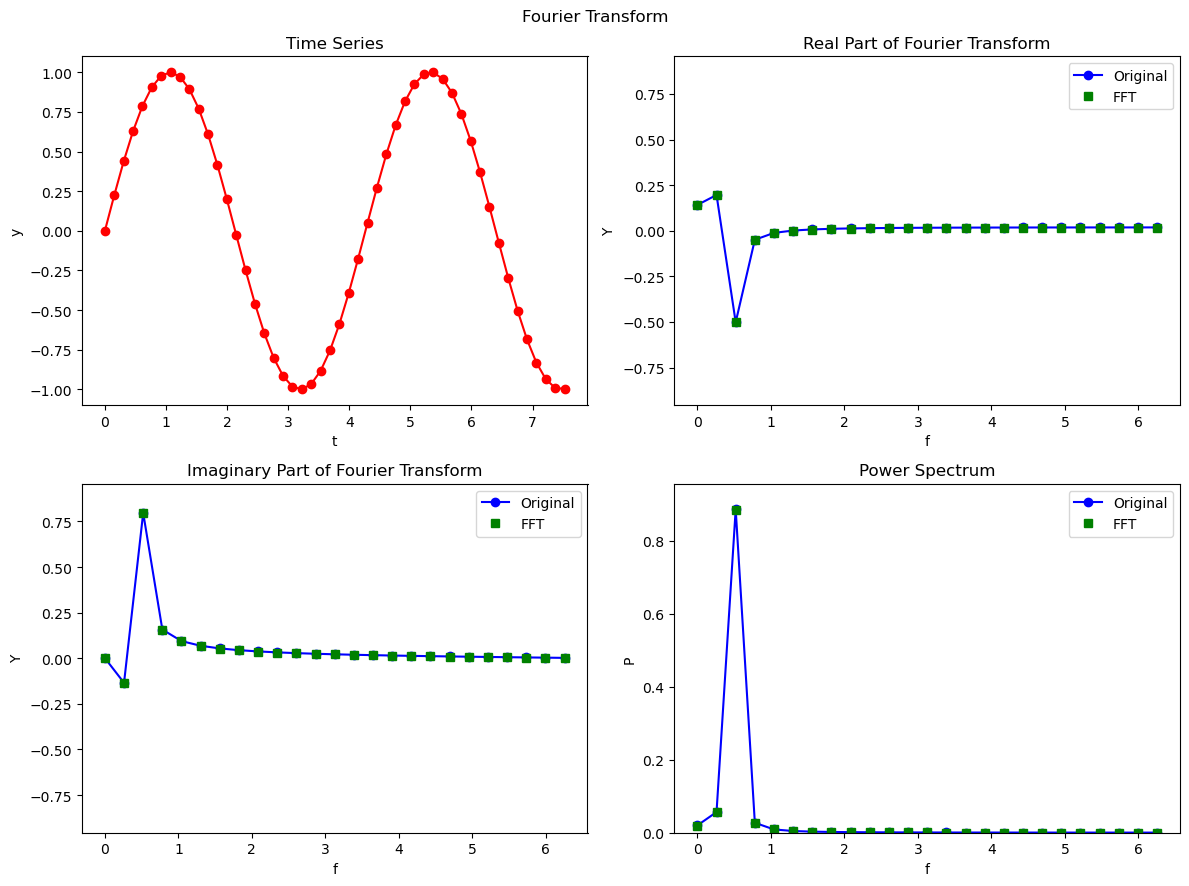

In [9]:
import matplotlib.pyplot as plt
import numpy as np

Ns = N_samples
Nt = N_terms

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle('Fourier Transform')

# Time Series
axs[0, 0].plot(t, y, marker='o', linestyle='-', color='red')
axs[0, 0].set_xlabel('t')
axs[0, 0].set_ylabel('y')
axs[0, 0].set_title('Time Series')

# Real Part of Fourier Transform
axs[0, 1].plot(f, ytReal, marker='o', linestyle='-', color='blue', label='Original')
axs[0, 1].plot(f, yfftReal[0:int(N_fft/2)], marker='s', linestyle='', color='green', label='FFT')
axs[0, 1].set_xlabel('f')
axs[0, 1].set_ylabel('Y')
axs[0, 1].set_title('Real Part of Fourier Transform')
axs[0, 1].set_ylim(-ymax, ymax)
axs[0, 1].legend()

# Imaginary Part of Fourier Transform
axs[1, 0].plot(f, ytImag, marker='o', linestyle='-', color='blue', label='Original')
axs[1, 0].plot(f, -yfftImag[0:int(N_fft/2)], marker='s', linestyle='', color='green', label='FFT')
axs[1, 0].set_xlabel('f')
axs[1, 0].set_ylabel('Y')
axs[1, 0].set_title('Imaginary Part of Fourier Transform')
axs[1, 0].set_ylim(-ymax, ymax)
axs[1, 0].legend()

# Power Spectrum
axs[1, 1].plot(f, power, marker='o', linestyle='-', color='blue', label='Original')
axs[1, 1].plot(f, powerfft[0:int(N_fft/2)], marker='s', linestyle='', color='green', label='FFT')
axs[1, 1].set_xlabel('f')
axs[1, 1].set_ylabel('P')
axs[1, 1].set_title('Power Spectrum')
axs[1, 1].set_ylim(0, ymax)
axs[1, 1].legend()

plt.tight_layout()
plt.show()


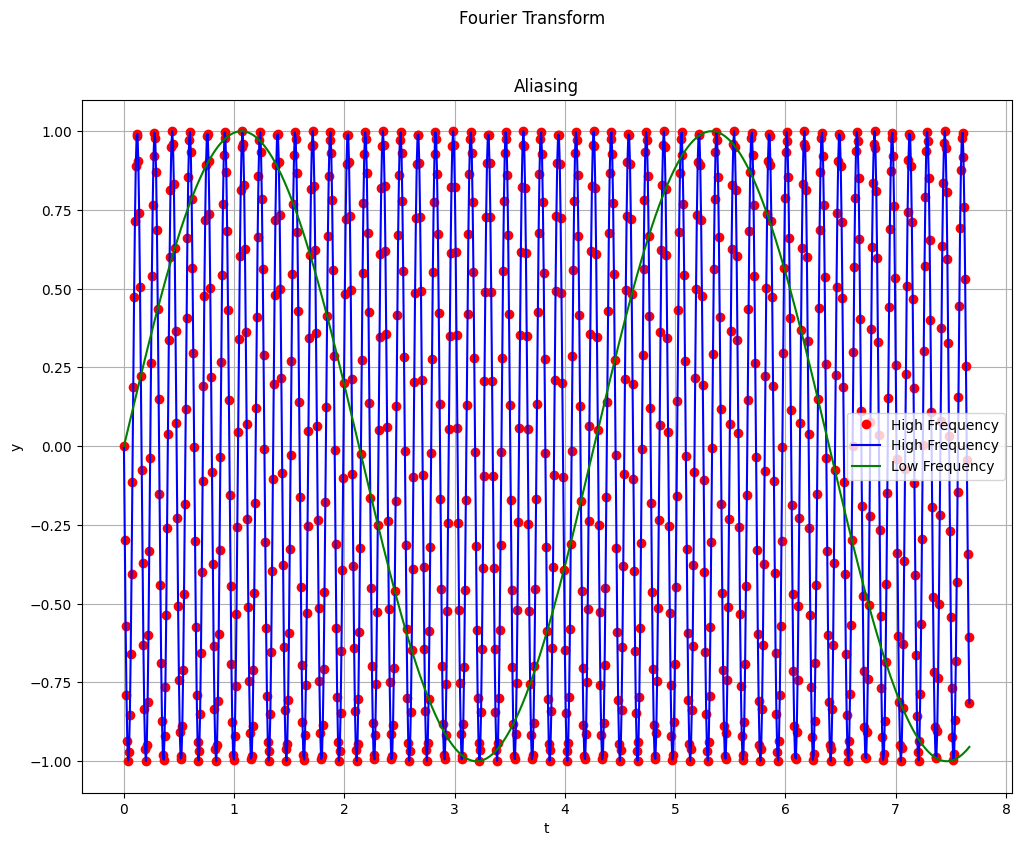

In [10]:

c2 = plt.figure(figsize=(12, 9))
c2.suptitle('Fourier Transform')

# Aliasing
ax = c2.add_subplot(111)
ax.plot(time, yhigh, marker='o', linestyle='', color='red', label='High Frequency')
ax.plot(time, yhigh, marker='', linestyle='-', color='blue', label='High Frequency')
ax.plot(time, ylow, linestyle='-', color='green', label='Low Frequency')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.set_title('Aliasing')
ax.legend()

plt.grid(True)
plt.show()